# LLM Benchmark & Visualization
This notebook demonstrates how to use the `llama-benchy` library to benchmark an LLM and visualize the results.
To run it, you need to install the dependencies: `uv pip install jupyterlab`, then run `jupyter lab`

In [1]:
!uv pip install matplotlib seaborn pandas ipywidgets

Using Python 3.12.7 environment at: /Users/eugr/Documents/src-personal/llm-bench/.venv
Audited 4 packages in 37ms


In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import asyncio
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure src is in the python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

from llama_benchy.config import BenchmarkConfig
from llama_benchy.client import LLMClient
from llama_benchy.corpus import TokenizedCorpus
from llama_benchy.prompts import PromptGenerator
from llama_benchy.runner import BenchmarkRunner

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


## Configuration

Configure the benchmark parameters below. Set your API key and Base URL.
If you are running a local server (e.g., vllm, TGI), the base URL usually looks like `http://localhost:8000/v1`.

In [3]:
# --- USER CONFIGURATION ---
BASE_URL = "http://spark:8888/v1"
API_KEY = "EMPTY"  # Use your actual API key if needed
MODEL_NAME = "openai/gpt-oss-120b" # Change to your model name
SERVED_MODEL_NAME = MODEL_NAME # "gpt-oss-120b"

# Benchmark parameters
CONCURRENCY_LEVELS = [1, 2, 4]
PROMPT_SIZES = [128, 1024, 4096]
GEN_SIZES = [128]
RUNS = 3
# --------------------------

print(f"Configured to benchmark {MODEL_NAME} at {BASE_URL} served as {SERVED_MODEL_NAME}")

Configured to benchmark openai/gpt-oss-120b at http://spark:8888/v1 served as openai/gpt-oss-120b


In [4]:
# Initialize Components

# 1. Config
config = BenchmarkConfig(
    base_url=BASE_URL,
    api_key=API_KEY,
    model=MODEL_NAME,
    served_model_name=SERVED_MODEL_NAME,
    tokenizer=None, # Will auto-detect from model name or fallback
    pp_counts=PROMPT_SIZES,
    tg_counts=GEN_SIZES,
    depths=[0],
    num_runs=RUNS,
    no_cache=False,
    latency_mode="api",
    no_warmup=False,
    adapt_prompt=True,
    enable_prefix_caching=False,
    book_url="https://www.gutenberg.org/files/1661/1661-0.txt",
    post_run_cmd=None,
    concurrency_levels=CONCURRENCY_LEVELS,
    save_all_throughput_timeseries=True,
    save_total_throughput_timeseries=True
)

# 2. Corpus (Downloads text for prompt generation)
print("Initializing Corpus...")
corpus = TokenizedCorpus(config.book_url, config.tokenizer, config.model)

# 3. Prompt Generator
prompt_gen = PromptGenerator(corpus)

# 4. Client
client = LLMClient(config.base_url, config.api_key, config.served_model_name)

# 5. Runner
runner = BenchmarkRunner(config, client, prompt_gen)
print(f"Runner initialized. Config: {config}")

Initializing Corpus...
Loading text from cache: /Users/eugr/.cache/llama-benchy/cc6a0b5782734ee3b9069aa3b64cc62c.txt
Runner initialized. Config: BenchmarkConfig(base_url='http://spark:8888/v1', api_key='EMPTY', model='openai/gpt-oss-120b', served_model_name='openai/gpt-oss-120b', tokenizer=None, pp_counts=[128, 1024, 4096], tg_counts=[128], depths=[0], num_runs=3, no_cache=False, latency_mode='api', no_warmup=False, adapt_prompt=True, enable_prefix_caching=False, book_url='https://www.gutenberg.org/files/1661/1661-0.txt', post_run_cmd=None, concurrency_levels=[1, 2, 4], save_result=None, result_format='md', save_total_throughput_timeseries=True, save_all_throughput_timeseries=True)


## Run Benchmark

The following cell executes the benchmark suite. This may take a while depending on the number of runs and concurrency levels.

In [5]:
print("Starting Benchmark Suite...")
await runner.run_suite()
print("Benchmark completed.")

Starting Benchmark Suite...
Warming up...
Warmup (User only) complete. Delta: 65 tokens (Server: 86, Local: 21)
Warmup (System+Empty) complete. Delta: 69 tokens (Server: 90, Local: 21)
Measuring latency using mode: api...
Average latency (api): 5.19 ms
Running test: pp=128, tg=128, depth=0, concurrency=1
  Run 1/3 (batch size 1)...
  Run 2/3 (batch size 1)...
  Run 3/3 (batch size 1)...
Running test: pp=128, tg=128, depth=0, concurrency=2
  Run 1/3 (batch size 2)...
  Run 2/3 (batch size 2)...
  Run 3/3 (batch size 2)...
Running test: pp=128, tg=128, depth=0, concurrency=4
  Run 1/3 (batch size 4)...
  Run 2/3 (batch size 4)...
  Run 3/3 (batch size 4)...
Running test: pp=1024, tg=128, depth=0, concurrency=1
  Run 1/3 (batch size 1)...
  Run 2/3 (batch size 1)...
  Run 3/3 (batch size 1)...
Running test: pp=1024, tg=128, depth=0, concurrency=2
  Run 1/3 (batch size 2)...
  Run 2/3 (batch size 2)...
  Run 3/3 (batch size 2)...
Running test: pp=1024, tg=128, depth=0, concurrency=4
  Run 

## Analysis & Visualization

Process the collected results into a Pandas DataFrame and generate plots.

In [6]:
# Extract Data
data = []

# Access the raw run data from the results object
for run in runner.results.runs:
    # Check if metrics exist (they might be None if runs failed)
    ts_mean = run.pp_throughput.mean if run.pp_throughput else 0
    tg_mean = run.tg_throughput.mean if run.tg_throughput else 0
    peak_mean = run.peak_throughput.mean if run.peak_throughput else 0
    ttft_mean = run.e2e_ttft.mean if run.e2e_ttft else 0
    
    data.append({
        "Concurrency": run.concurrency,
        "Prompt Size": run.prompt_size,
        "Output Size": run.response_size,
        "Prefill Throughput (t/s)": ts_mean,
        "Decode Throughput (t/s)": tg_mean,
        "Peak Throughput (t/s)": peak_mean,
        "TTFT (ms)": ttft_mean * 1000 # Convert to ms
    })

df = pd.DataFrame(data)
display(df)

,Concurrency,Prompt Size,Output Size,Prefill Throughput (t/s),Decode Throughput (t/s),Peak Throughput (t/s),TTFT (ms)
0,1,128,128,577.151891,75.294373,76.000000,1.563626e+05
1,2,128,128,599.345983,110.699988,114.000000,2.161121e+05
2,4,128,128,746.231821,161.538835,171.000000,3.306915e+05
3,1,1024,128,5056.710166,73.313071,75.333333,2.503521e+05
4,2,1024,128,4236.724333,109.169830,111.666667,4.738184e+05
5,4,1024,128,6374.555434,160.827376,168.000000,6.337404e+05
6,1,4096,128,8214.154156,74.387720,75.666667,5.480726e+05
7,2,4096,128,8645.727739,107.495367,110.000000,9.474032e+05
8,4,4096,128,8689.611216,156.665158,165.333333,1.872285e+06


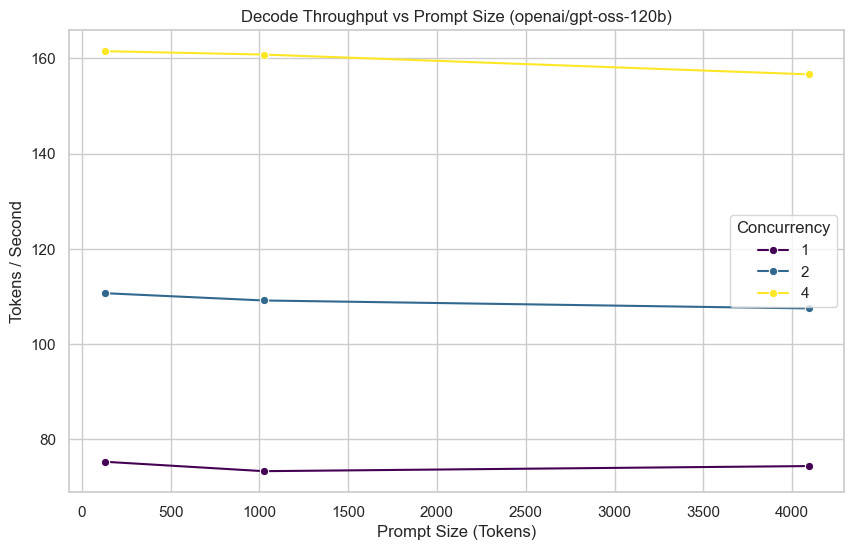

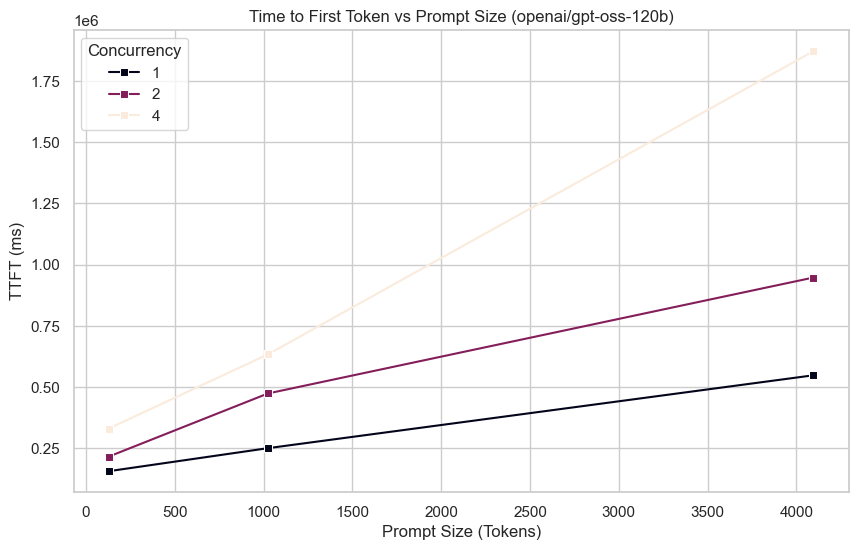

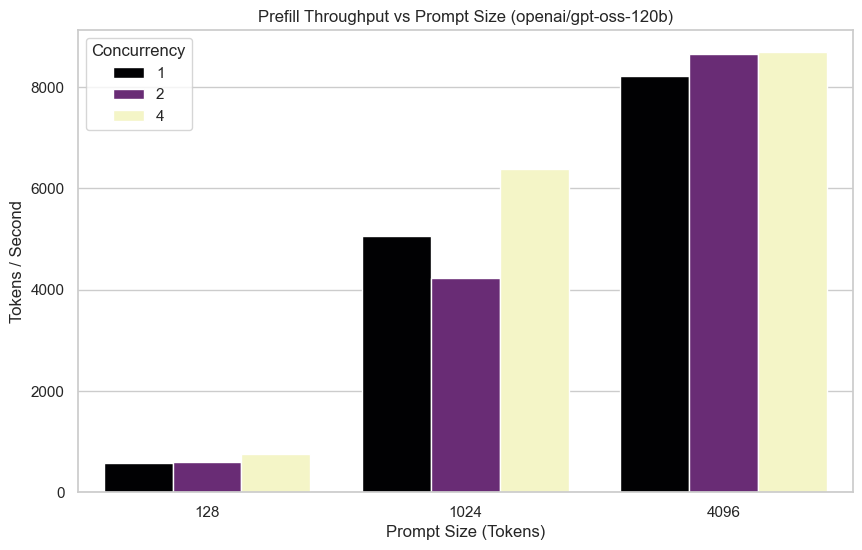

In [7]:
# Visualization

sns.set_theme(style="whitegrid")

# Plot 1: Decode Throughput vs Prompt Size (grouped by Concurrency)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Prompt Size", y="Decode Throughput (t/s)", hue="Concurrency", marker="o", palette="viridis")
plt.title(f"Decode Throughput vs Prompt Size ({MODEL_NAME})")
plt.ylabel("Tokens / Second")
plt.xlabel("Prompt Size (Tokens)")
plt.show()

# Plot 2: TTFT vs Prompt Size
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Prompt Size", y="TTFT (ms)", hue="Concurrency", marker="s", palette="rocket")
plt.title(f"Time to First Token vs Prompt Size ({MODEL_NAME})")
plt.ylabel("TTFT (ms)")
plt.xlabel("Prompt Size (Tokens)")
plt.show()

# Plot 3: Prefill Throughput
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="Prompt Size", y="Prefill Throughput (t/s)", hue="Concurrency", palette="magma")
plt.title(f"Prefill Throughput vs Prompt Size ({MODEL_NAME})")
plt.ylabel("Tokens / Second")
plt.xlabel("Prompt Size (Tokens)")
plt.show()

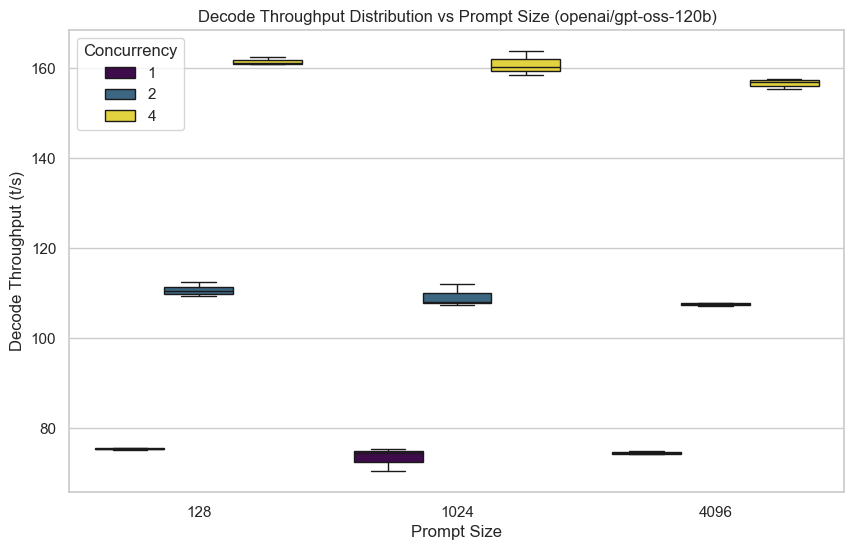

In [8]:
# Whisker plot for Decode Throughput vs Prompt Size
# Collect raw decode throughput samples for each configuration
samples = []
for run in runner.results.runs:
    # Attempt to get individual samples; fallback to mean if not available
    tg_samples = getattr(run.tg_throughput, "values", [run.tg_throughput.mean])
    for val in tg_samples:
        samples.append({
            "Concurrency": run.concurrency,
            "Prompt Size": run.prompt_size,
            "Decode Throughput (t/s)": val,
        })

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_samples = pd.DataFrame(samples)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_samples, x="Prompt Size", y="Decode Throughput (t/s)", hue="Concurrency", palette="viridis")
plt.title(f"Decode Throughput Distribution vs Prompt Size ({MODEL_NAME})")
plt.show()

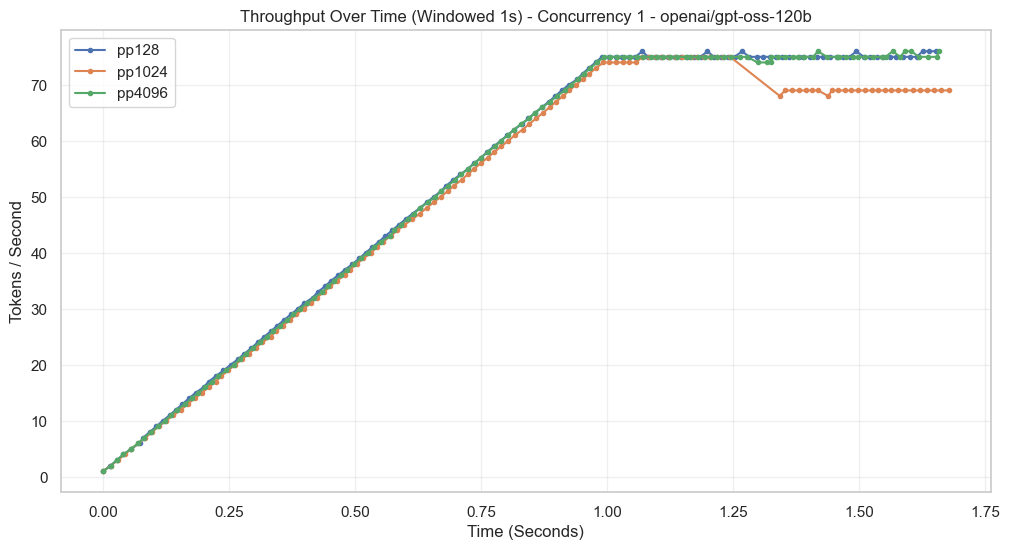

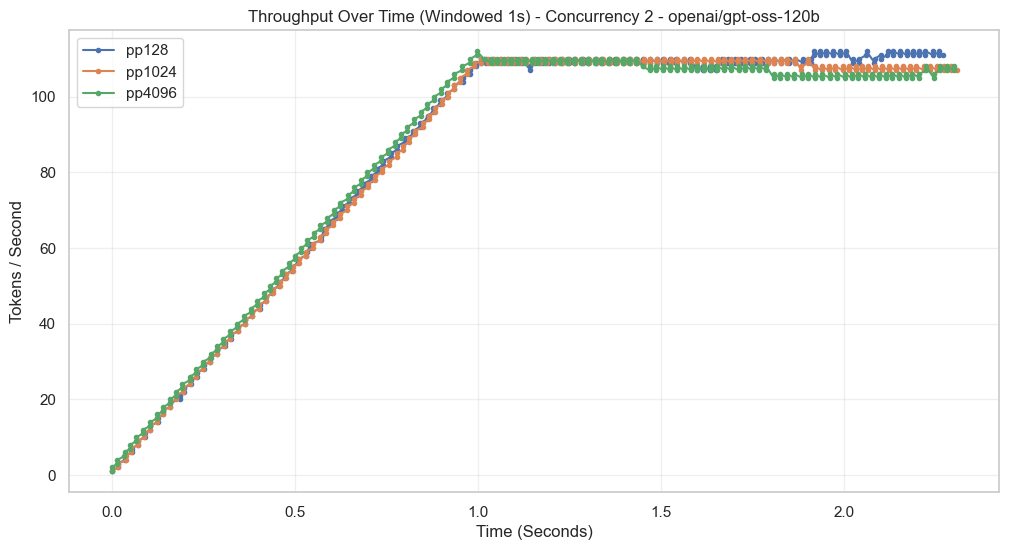

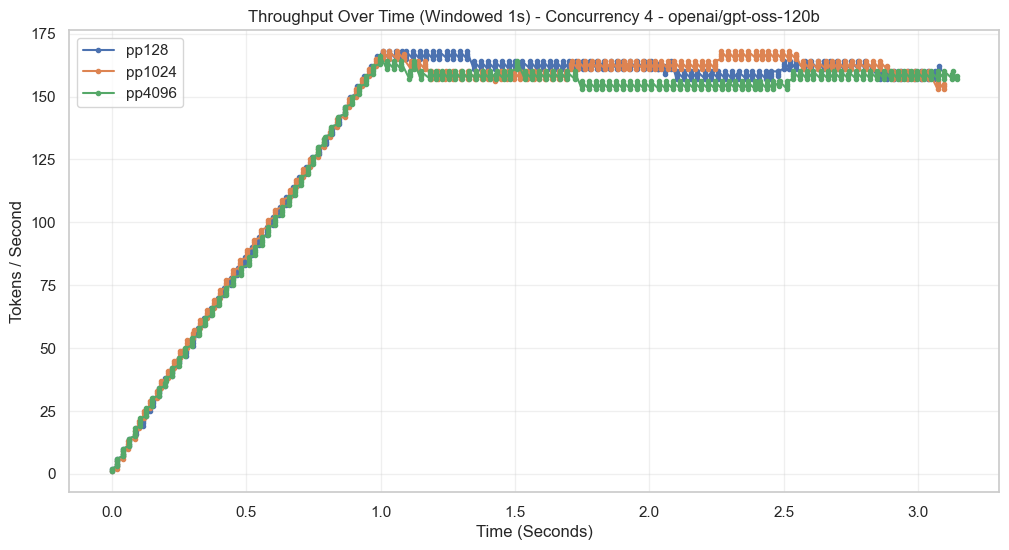

In [9]:
# Plot Throughput Over Time
has_data = False
unique_concurrencies = sorted(list(set(run.concurrency for run in runner.results.runs)))

for concurrency in unique_concurrencies:
    plt.figure(figsize=(12, 6))
    runs_for_concurrency = [r for r in runner.results.runs if r.concurrency == concurrency]
    
    plotted_any = False
    for run in runs_for_concurrency:
        if run.throughput_over_time and len(run.throughput_over_time) > 0:
            has_data = True
            plotted_any = True
            # Plot the first iteration's time series
            # Series is now [relative_time, throughput]
            series_data = run.throughput_over_time[0]
            
            # Extract basic lists for plotting
            if isinstance(series_data[0], (list, tuple)):
                times = [p[0] for p in series_data]
                values = [p[1] for p in series_data]
            else:
                # Fallback for old data format (just values)
                values = series_data
                times = range(len(values))
            
            label = f"pp{run.prompt_size}"
            plt.plot(times, values, label=label, marker='o', markersize=3)
    
    if plotted_any:
        plt.title(f"Throughput Over Time (Windowed 1s) - Concurrency {concurrency} - {MODEL_NAME}")
        plt.ylabel("Tokens / Second")
        plt.xlabel("Time (Seconds)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

if not has_data:
    print("No time-series data available. Ensure save_all_throughput_data=True in config.")

## Throughput Over Time
This plot shows the throughput stability over the duration of the test runs. We pick the first run for each configuration.

## Export Results

Save the raw results to a JSON file.

In [10]:
output_file = "benchmark_results.json"
runner.results.save_report(output_file, "json")
print(f"Results saved to {output_file}")

Saving results to benchmark_results.json in JSON format...


Results saved to benchmark_results.json
